# Homework 3
## Dylan Green - 22420153
I hope submission via Jupyter notebook is okay - I had planned to move these results to a latex document but then ended up spending extra time on Program 5, and need to move on to other things. I discussed this assignment in depth with many students, but in particular Masoud Mokhtari and Geoff Woollard (as well as Wilder Lavington for Program 5). 

In [1]:
import json
import torch
from hmc import hmc
from mh_within_gibbs import gibbs_sampling
from likelihood_weighting import likelihood_weighting
import matplotlib.pyplot as plt
import numpy as np
import time

Load in graphs and asts.

In [2]:
f = open('graphs/1.json', 'rb')
g1 = json.load(f)
f.close()
f = open('graphs/2.json', 'rb')
g2 = json.load(f)
f.close()
f = open('graphs/3.json', 'rb')
g3 = json.load(f)
f.close()
f = open('graphs/4.json', 'rb')
g4 = json.load(f)
f.close()
f = open('graphs/5.json', 'rb')
g5 = json.load(f)
f.close()

In [3]:
f = open('asts/1.json', 'rb')
ast1 = json.load(f)
f.close()
#print(ast1)
#print('\n\n')

f = open('asts/2.json', 'rb')
ast2 = json.load(f)
f.close()
#print(ast2)
#print('\n\n')

f = open('asts/3.json', 'rb')
ast3 = json.load(f)
f.close()
#print(ast3)
#print('\n\n')

f = open('asts/4.json', 'rb')
ast4 = json.load(f)
f.close()
#print(ast4)
#print('\n\n')

f = open('asts/5.json', 'rb')
ast5 = json.load(f)
f.close()
#print(ast5)
#print('\n\n')

# Code

Relevant code snippets are included below. All code can be found at https://github.com/lone-duck/hw-cs532/tree/main/hw3.

## Importance Sampling

In [ ]:
def likelihood_weighting(ast, L):
    """
    Generate likelihood weighted samples from a program desugared by Daphne.
    Args:
        ast: json FOPPL program
        L: number of samples to generate
    Return:
        L samples and likelihood weights in a dictionary
    """
    returns = [None]*L
    log_weights = [None]*L

    for l in range(L):
        returns[l], log_weights[l] = evaluate_program(ast)

    return {'returns': returns, 'log_weights': log_weights}


def evaluate_program(ast):
    """Evaluate a program as desugared by daphne, generate a sample from the prior
    Args:
        ast: json FOPPL program
    Returns: 
        samples with likelihood weights
    """
    global ENV
    ENV = eval_env()
    for defn in ast[:-1]:
        f_name = defn[1]
        f_v_is = defn[2]
        f_expr = defn[3]
        ENV.update({f_name: (f_v_is, f_expr)})
    l = {}
    sig = {'logW': 0}
    ret, sig = evaluate(ast[-1], l, sig)
    return ret, sig['logW']

# inspired by https://norvig.com/lispy.html
def evaluate(e, l, sig):
    # variable reference OR procedure OR just a string
    if isinstance(e, str):        
        # global procedures take precedence over locally defined vars
        if e in ENV:
            return ENV[e], sig
        elif e in l:
            return l[e], sig
        # could allow for hashmaps with string keys; for debugging setting this to fail
        else:
            assert False, "Unknown symbol: {}".format(e)
    # constant number
    elif isinstance(e, (int, float)):   
        return torch.tensor(float(e)), sig
    # if statements
    elif e[0] == 'if':
        (_, test, conseq, alt) = e
        test_value, sig = evaluate(test, l, sig)
        expr = (conseq if test_value else alt)
        return evaluate(expr, l, sig)
    # let statements
    elif e[0] == 'let':
        # get symbol
        symbol = e[1][0]
        # get value of e1
        value, sig = evaluate(e[1][1], l, sig)
        # evaluate e2 with value 
        return evaluate(e[2], {**l, symbol: value}, sig)
    # sample statement
    if e[0] == 'sample':
        dist, sig = evaluate(e[1], l, sig)
        # make sure it is a distribution object
        assert getattr(dist, '__module__', None).split('.')[:2] == ['torch', 'distributions']
        return dist.sample(), sig
    # observe statements
    if e[0] == 'observe':
        dist, sig = evaluate(e[1], l, sig) # get dist
        y, sig = evaluate(e[2], l, sig)    # get observed value
        # make sure it is a distribution object
        assert getattr(dist, '__module__', None).split('.')[:2] == ['torch', 'distributions']
        sig['logW'] = sig['logW'] + dist.log_prob(y)
        return y, sig
    # procedure call, either primitive or user-defined
    else:            
        proc, sig = evaluate(e[0], l, sig)
        # primitives are functions
        if callable(proc):
            args = [None]*len(e[1:])
            for i, arg in enumerate(e[1:]):
                result, sig = evaluate(arg, l, sig)
                args[i] = result
            result = proc(*args)
            return result, sig
        # user defined functions are not
        else:
            # as written in algorithm 6
            v_is, e0 = proc 
            assert(len(v_is) == len(e[1:]))
            c_is = [None]*len(e[1:])
            for i, arg in enumerate(e[1:]):
                result, sig = evaluate(arg, l, sig)
                c_is[i] = result
            l_proc = dict(zip(v_is, c_is))
            return evaluate(e0, {**l, **l_proc}, sig)

## MH within Gibbs

In [ ]:
def sample_from_prior(graph):
    # get contents of graph
    fn_defs = graph[0]
    V = graph[1]['V']
    A = graph[1]['A']
    P = graph[1]['P']
    Y = graph[1]['Y']
    ret_vals = graph[2]
    
    # deal with fn_defs
    global ENV
    ENV = eval_env()
    for defn in fn_defs.items():
        f_name = defn[0]
        f_v_is = defn[1][1]
        f_expr = defn[1][2]
        ENV.update({f_name: (f_v_is, f_expr)})
    
    # get sorted V
    sorted_V = topological_sort(A, V)

    # compute each value in order
    l = {}
    for v in sorted_V:
        task, expr = P[v][0], P[v][1]
        if task == "sample*":
            dist, _ = deterministic_evaluate(expr, l)
            l.update({v: dist.sample()})

    return l


def joint_log_likelihood(X, graph):
    P = graph[1]['P']
    Y = {k: torch.tensor(v).float() for k, v in graph[1]['Y'].items()}
    V = {**X, **Y}
    Vkeys = list(V.keys())
    jll = 0

    for v in Vkeys:
        expr = P[v][1]
        p_v, _ = deterministic_evaluate(expr, V)
        jll += p_v.log_prob(V[v])

    return jll



def gibbs_sampling(graph, S, X0=None, verbose=False, return_samples=False):

    if return_samples:
        samples = [None]*S
    
    jlls = [None]*S
    ret_vals = [None]*S

    if X0 is None:
        X0 = sample_from_prior(graph)

    Xprev = X0

    for s in range(S):
        if verbose:
            print(s)
        X, ret_vals[s] = gibbs_step(Xprev, graph)
        if return_samples:
            samples[s] = X
        jlls[s] = joint_log_likelihood(X, graph)
        Xprev = X

    if return_samples:
        return ret_vals, jlls, samples
    else:
        return ret_vals, jlls


def gibbs_step(X, graph):

    P = graph[1]['P']
    unif = torch.distributions.Uniform(0,1)
    Xkeys = list(X.keys())
    ret_vals = graph[2]

    for x in Xkeys:
        task, expr = P[x][0], P[x][1]
        assert task == "sample*", "Found observed variable in X???"
        q, _ = deterministic_evaluate(expr, X)
        Xprime = X.copy()
        Xprime[x] = q.sample()
        alpha = accept(x, Xprime, X, graph)
        u = unif.sample()
        if u < alpha:
            X = Xprime

    return X, deterministic_evaluate(ret_vals, X)[0]


def accept(x, Xprime, X, graph):
    P = graph[1]['P']
    Y = {k: torch.tensor(v).float() for k, v in graph[1]['Y'].items()}
    A = graph[1]['A']
    log_alpha = 0.0

    task, expr = P[x][0], P[x][1]
    assert task == "sample*", "Found observed variable in X???"
    q, _ = deterministic_evaluate(expr, X)
    qprime, _ = deterministic_evaluate(expr, Xprime)
    log_alpha += (qprime.log_prob(X[x]) - q.log_prob(Xprime[x]))
    
    V_x = A[x] + [x]
    XUY = {**X, **Y}
    XprimeUY = {**Xprime, **Y}
    for v in V_x:
        task, expr = P[v][0], P[v][1]
        p_v, _ = deterministic_evaluate(expr, XprimeUY)
        log_alpha += p_v.log_prob(XprimeUY[v])
        p_v, _ = deterministic_evaluate(expr, XUY)
        log_alpha -= p_v.log_prob(XUY[v])

    return torch.exp(log_alpha)

## HMC

In [ ]:
def hmc(graph, S, X0=None, T=20, epsilon=0.1, m=1, return_samples=False, report_acceptance_rate=False):
    # NOTE: for now, assume that len(X) is dimensionality of R
    # this may not be the case if element of X are vectors themselves
    
    if return_samples:
        samples = [None]*S
    if report_acceptance_rate:
        accepts = 0
    
    jlls = [None]*S
    ret_vals = [None]*S

    if X0 is None:
        X0 = sample_from_prior(graph)

    Xprev = X0
    Xdim = len(X0)

    ret_expr = graph[2]

    R_dist = torch.distributions.MultivariateNormal(torch.zeros(Xdim), m*torch.eye(Xdim))
    unif = torch.distributions.uniform.Uniform(0, 1)

    for s in range(S):
        # get a new R
        R_vals = R_dist.sample()
        R = dict(zip(Xprev.keys(), R_vals))
        Xprime, Rprime = leapfrog(graph, copy.deepcopy(Xprev), copy.deepcopy(R), T, epsilon)
        # compute acceptance values
        u = unif.sample()
        alpha = accept(graph, Xprev, R, Xprime, Rprime, m)
        # based on acceptance values, choose which X to keep
        if u < alpha:
            if report_acceptance_rate:
                accepts +=1
            Xkeep = Xprime
        else:
            Xkeep = Xprev

        # store appropriate things
        if return_samples:
            samples[s] = Xkeep
        ret_vals[s] = deterministic_evaluate(ret_expr, Xkeep)[0]
        jlls[s] = joint_log_likelihood(Xkeep, graph)

        # update Xprev
        Xprev = Xkeep

    if report_acceptance_rate:
        print("Acceptance rate: {}".format(accepts/S))

    if return_samples:
        return ret_vals, jlls, samples
    else:
        return ret_vals, jlls


def leapfrog(graph, X, R, T, epsilon):
    gradU = get_grad_U(graph, X)
    R = R_update(R, gradU, epsilon, half_step=True)

    for t in range(T-1):
        X = X_update(X, R, epsilon)
        gradU = get_grad_U(graph, X)
        R = R_update(R, gradU, epsilon)

    X = X_update(X, R, epsilon)
    gradU = get_grad_U(graph, X)
    R = R_update(R, gradU, epsilon, half_step=True)
    return X, R


def get_grad_U(graph, X):

    P = graph[1]['P']
    Y = {k: torch.tensor(v).float() for k, v in graph[1]['Y'].items()}
    V = {**X, **Y}
    Vkeys = list(V.keys())
    U = 0
    for v in Vkeys:
        V[v].requires_grad=True
        if V[v].grad != None:
            V[v].grad.zero_()
    for v in Vkeys:
        expr = P[v][1]
        p_v, _ = deterministic_evaluate(expr, V)
        U += p_v.log_prob(V[v])

    U *= -1
    U.backward()
    gradU = {key: value.grad for key, value in X.items()}

    return gradU


def R_update(R, gradU, epsilon, half_step=False):
    
    keys = list(R.keys())
    if half_step:
        epsilon = 0.5*epsilon

    for r in keys:
        R[r] -= epsilon*gradU[r]

    return R


def X_update(X, R, epsilon):
    keys = list(X.keys())

    for x in keys:
        X[x].requires_grad = False
        X[x] += epsilon*R[x]

    return X


def accept(graph, X, R, Xprime, Rprime, m):
    
    K = 0
    for r in R.values():
        K += 0.5*r**2/m
    U = -1*joint_log_likelihood(X, graph)
    H = K + U

    Kprime = 0 
    for r in Rprime.values():
        Kprime += 0.5*r**2/m 
    Uprime = -1*joint_log_likelihood(Xprime, graph)
    Hprime = Kprime + Uprime

    return torch.exp(-Hprime + H)

## Augmented MH Gibbs for Program 5

For one approach to program 5, slight modifications were made to the gibbs_step and accept functions. The motivation for these changes is discussed in the Program 5 with MH Gibbs section.

In [ ]:
def gibbs_step(X, graph, s):

    P = graph[1]['P']
    unif = torch.distributions.Uniform(0,1)
    Xkeys = list(X.keys())
    ret_vals = graph[2]

    if s % 2 == 0:
        sampled = 'sample1'
        deterministic = 'sample2'
    else:
        sampled = 'sample2'
        deterministic = 'sample1'


    for x in Xkeys:
        task, expr = P[x][0], P[x][1]
        assert task == "sample*", "Found observed variable in X???"
        q, _ = deterministic_evaluate(expr, X)
        Xprime = X.copy()
        if x == sampled:
            Xprime[x] = q.sample()
        elif x == deterministic:
            Xprime[x] = 7 - Xprime['sample1']
        else:
            assert False, "found x == {}".format(x)
        alpha = accept(x, Xprime, X, graph)
        u = unif.sample()
        if u < alpha:
            X = Xprime

    return X, deterministic_evaluate(ret_vals, X)[0]


def accept(x, Xprime, X, graph):
    P = graph[1]['P']
    Y = {k: torch.tensor(v).float() for k, v in graph[1]['Y'].items()}
    A = graph[1]['A']
    log_alpha = 0.0

    task, expr = P[x][0], P[x][1]
    assert task == "sample*", "Found observed variable in X???"
    q, _ = deterministic_evaluate(expr, X)
    qprime, _ = deterministic_evaluate(expr, Xprime)
    log_alpha += (qprime.log_prob(X[x]) - q.log_prob(Xprime[x]))
    
    V_x = A[x] + [x]
    XUY = {**X}
    XprimeUY = {**Xprime}
    for v in V_x:
        if v != 'observe3':
            task, expr = P[v][0], P[v][1]
            p_v, _ = deterministic_evaluate(expr, XprimeUY)
            log_alpha += p_v.log_prob(XprimeUY[v])
            p_v, _ = deterministic_evaluate(expr, XUY)
            log_alpha -= p_v.log_prob(XUY[v])

    return torch.exp(log_alpha)

# Program 1

## Importance Sampling

### To the grader: sorry if you didn't want to look at code and I made you flip through many pages of it to get here... otherwise it wouldn't have been attached to any question and I didn't want to get dinged in case you couldn't find it.

In [11]:
start = time.time()
result = likelihood_weighting(ast1, 100000) 
end = time.time()

In [12]:
print(end-start)

19.533912897109985


In [16]:
returns = torch.stack(result['returns']).float()
log_weights = torch.stack(result['log_weights'])
M = torch.max(log_weights)
normalized_weights = torch.exp(log_weights - M)/torch.sum(torch.exp(log_weights - M))
weighted_returns = normalized_weights*returns
expectation = torch.sum(weighted_returns)
returns_squared = returns*returns
variance = torch.sum(normalized_weights*returns_squared) - expectation*expectation
print("Expectation: {}".format(expectation.item()))
print("Variance: {}".format(variance.item()))

Expectation: 7.236835956573486
Variance: 0.8446235656738281


Text(0, 0.5, 'frequency')

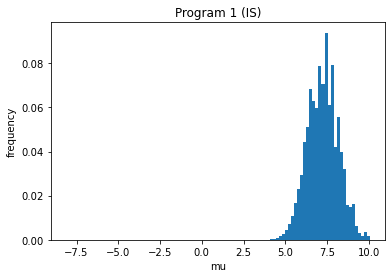

In [44]:
plt.hist(returns.numpy(), weights=normalized_weights.numpy(), bins=100)
plt.title("Program 1 (IS)")
plt.xlabel("mu")
plt.ylabel("frequency")

## MH Gibbs

In [37]:
start = time.time()
ret_vals, jlls = gibbs_sampling(g1, 100000)
end = time.time()

In [38]:
print(end-start)

94.85253596305847


In [39]:
ret_vals = torch.stack(ret_vals)
expectation = torch.mean(ret_vals)
variance = torch.std(ret_vals)**2
print('Expectation: {}'.format(expectation.item()))
print('Variance: {}'.format(variance.item()))

Expectation: 7.240914344787598
Variance: 0.8320391178131104


Text(0, 0.5, 'frequency')

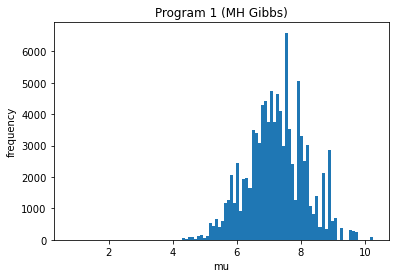

In [47]:
plt.hist(ret_vals.numpy(), bins=100)
plt.title("Program 1 (MH Gibbs)")
plt.xlabel("mu")
plt.ylabel("frequency")

Text(0, 0.5, 'mu')

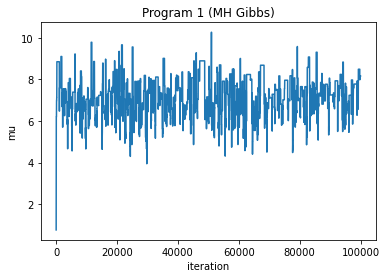

In [48]:
plt.plot(ret_vals.numpy())
plt.title("Program 1 (MH Gibbs)")
plt.xlabel("iteration")
plt.ylabel("mu")

Text(0, 0.5, 'JLL')

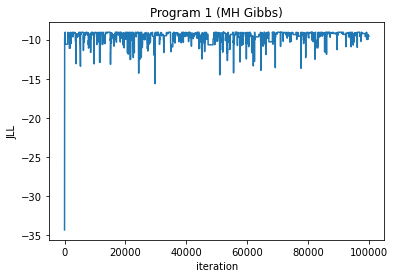

In [49]:
jlls = torch.stack(jlls)
plt.plot(jlls.numpy())
plt.title("Program 1 (MH Gibbs)")
plt.xlabel("iteration")
plt.ylabel("JLL")

## HMC

In [58]:
start = time.time()
ret_vals, jlls = hmc(g1, 10000)
end = time.time()

In [59]:
print(end-start)

128.04001998901367


In [60]:
ret_vals = torch.stack(ret_vals)
expectation = torch.mean(ret_vals)
variance = torch.std(ret_vals)**2
print('Expectation: {}'.format(expectation.item()))
print('Variance: {}'.format(variance.item()))

Expectation: 7.2495436668396
Variance: 0.8493431210517883


Text(0, 0.5, 'frequency')

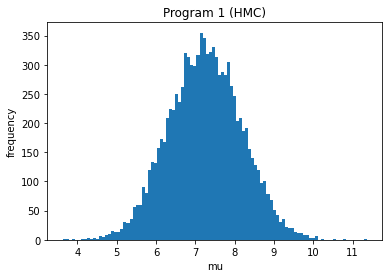

In [62]:
plt.hist(ret_vals.detach().numpy(), bins=100)
plt.title("Program 1 (HMC)")
plt.xlabel("mu")
plt.ylabel("frequency")

Text(0, 0.5, 'mu')

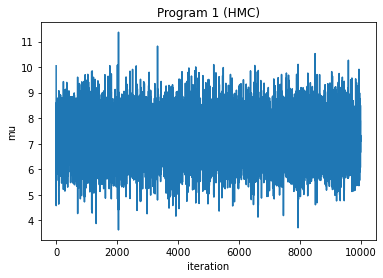

In [63]:
plt.plot(ret_vals.detach().numpy())
plt.title("Program 1 (HMC)")
plt.xlabel("iteration")
plt.ylabel("mu")

Text(0, 0.5, 'JLL')

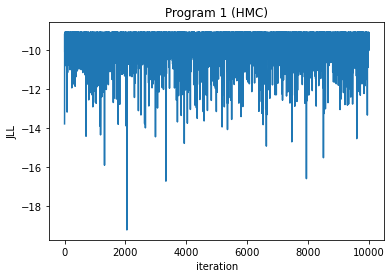

In [64]:
jlls = torch.stack(jlls)
plt.plot(jlls.detach().numpy())
plt.title("Program 1 (HMC)")
plt.xlabel("iteration")
plt.ylabel("JLL")

# Program 2

## Importance Sampling

In [68]:
start = time.time()
result = likelihood_weighting(ast2, 100000) 
end = time.time()

In [69]:
print(end-start)

85.87313389778137


In [75]:
returns = torch.stack(result['returns']).float()
log_weights = torch.stack(result['log_weights'])
M = torch.max(log_weights)
normalized_weights = torch.exp(log_weights - M)/torch.sum(torch.exp(log_weights - M))
weighted_returns = normalized_weights.unsqueeze(dim=1)*returns
expectation = torch.sum(weighted_returns, dim=0)
var00 = torch.sum(normalized_weights*returns[:,0]**2) - expectation[0]**2
var11 = torch.sum(normalized_weights*returns[:,1]**2) - expectation[1]**2
var01 = torch.sum(normalized_weights*returns[:,0]*returns[:,1]) - expectation[0]*expectation[1]
variance = torch.tensor([[var00, var01],[var01, var11]])
print("Expectation: {}".format(expectation.numpy()))
print("Covariance: ")
print(variance.numpy())

Expectation: [ 2.160934  -0.5681389]
Covariance: 
[[ 0.056458   -0.19934416]
 [-0.19934416  0.882903  ]]


Text(0, 0.5, 'frequency')

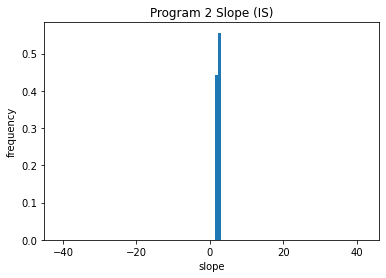

In [76]:
plt.hist(returns[:,0].numpy(), weights=normalized_weights.numpy(), bins=100)
plt.title("Program 2 Slope (IS)")
plt.xlabel("slope")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

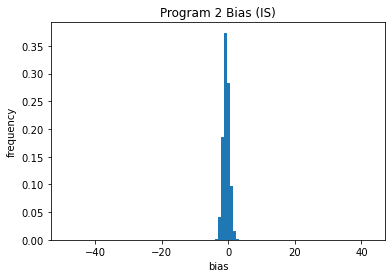

In [77]:
plt.hist(returns[:,1].numpy(), weights=normalized_weights.numpy(), bins=100)
plt.title("Program 2 Bias (IS)")
plt.xlabel("bias")
plt.ylabel("frequency")

# MH Gibbs

In [78]:
start = time.time()
ret_vals, jlls = gibbs_sampling(g2, 100000)
end = time.time()

In [79]:
print(end-start)

332.5917670726776


In [80]:
ret_vals = torch.stack(ret_vals).float()
jlls = torch.stack(jlls)
mean = torch.mean(ret_vals, dim=0).numpy()
slope = ret_vals[:,0].numpy()
bias = ret_vals[:,1].numpy()
print("Expectation: {}".format(mean))
print("Covariance: ")
print(np.cov(slope, bias))

Expectation: [ 2.1600854  -0.55851775]
Covariance: 
[[ 0.05755767 -0.19963064]
 [-0.19963064  0.8605278 ]]


Text(0, 0.5, 'frequency')

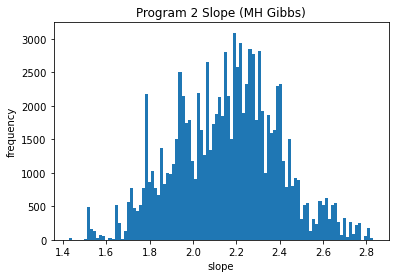

In [81]:
plt.hist(ret_vals[:,0].numpy(), bins=100)
plt.title("Program 2 Slope (MH Gibbs)")
plt.xlabel("slope")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

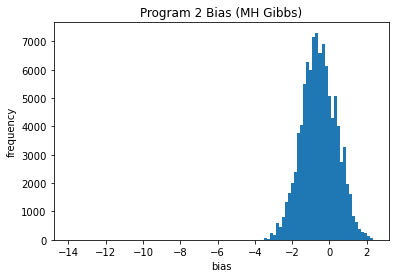

In [82]:
plt.hist(ret_vals[:,1].numpy(), bins=100)
plt.title("Program 2 Bias (MH Gibbs)")
plt.xlabel("bias")
plt.ylabel("frequency")

Text(0, 0.5, 'slope')

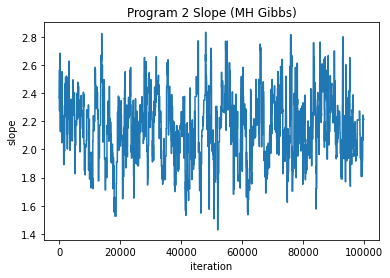

In [83]:
plt.plot(ret_vals[:,0].numpy())
plt.title("Program 2 Slope (MH Gibbs)")
plt.xlabel("iteration")
plt.ylabel("slope")

Text(0, 0.5, 'bias')

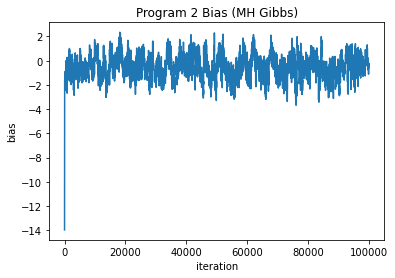

In [84]:
plt.plot(ret_vals[:,1].numpy())
plt.title("Program 2 Bias (MH Gibbs)")
plt.xlabel("iteration")
plt.ylabel("bias")

Text(0, 0.5, 'JLL')

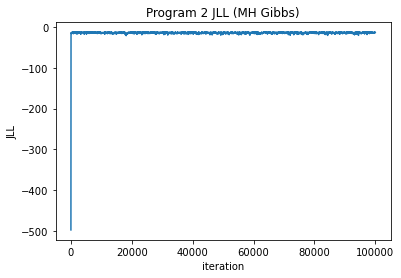

In [85]:
plt.plot(jlls.numpy())
plt.title("Program 2 JLL (MH Gibbs)")
plt.xlabel("iteration")
plt.ylabel("JLL")

## HMC

In [86]:
start = time.time()
ret_vals, jlls = hmc(g2, 10000)
end = time.time()

In [87]:
print(end-start)

328.93455505371094


In [91]:
#ret_vals = torch.stack(ret_vals).float()
#jlls = torch.stack(jlls)
mean = torch.mean(ret_vals, dim=0).detach().numpy()
slope = ret_vals[:,0].detach().numpy()
bias = ret_vals[:,1].detach().numpy()
print("Expectation: {}".format(mean))
print("Covariance: ")
print(np.cov(slope, bias))

Expectation: [ 2.147279   -0.49165174]
Covariance: 
[[ 0.05762292 -0.20308677]
 [-0.20308677  0.88447278]]


Text(0, 0.5, 'frequency')

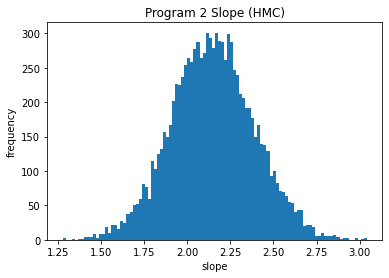

In [92]:
plt.hist(ret_vals[:,0].detach().numpy(), bins=100)
plt.title("Program 2 Slope (HMC)")
plt.xlabel("slope")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

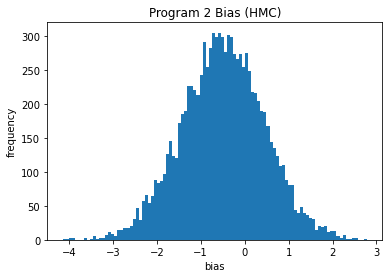

In [93]:
plt.hist(ret_vals[:,1].detach().numpy(), bins=100)
plt.title("Program 2 Bias (HMC)")
plt.xlabel("bias")
plt.ylabel("frequency")

Text(0, 0.5, 'slope')

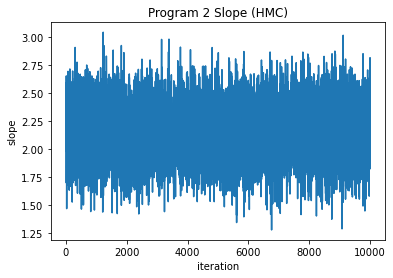

In [94]:
plt.plot(ret_vals[:,0].detach().numpy())
plt.title("Program 2 Slope (HMC)")
plt.xlabel("iteration")
plt.ylabel("slope")

Text(0, 0.5, 'bias')

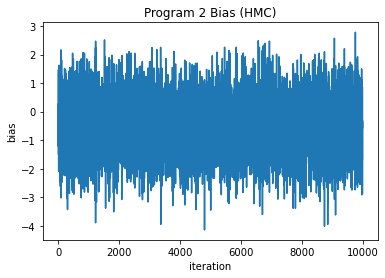

In [95]:
plt.plot(ret_vals[:,1].detach().numpy())
plt.title("Program 2 Bias (HMC)")
plt.xlabel("iteration")
plt.ylabel("bias")

Text(0, 0.5, 'JLL')

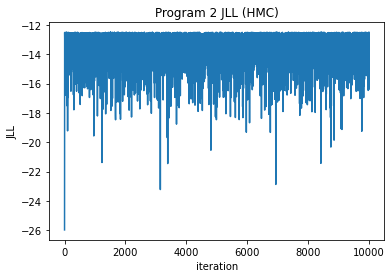

In [96]:
plt.plot(jlls.detach().numpy())
plt.title("Program 2 JLL (HMC)")
plt.xlabel("iteration")
plt.ylabel("JLL")

# Program 3

## Importance Sampling

In [99]:
start = time.time()
result = likelihood_weighting(ast3, 100000)
end = time.time()

In [100]:
print(end-start)

129.87191200256348


In [101]:
returns = torch.stack(result['returns']).float()
log_weights = torch.stack(result['log_weights'])
M = torch.max(log_weights)
normalized_weights = torch.exp(log_weights - M)/torch.sum(torch.exp(log_weights - M))
weighted_returns = normalized_weights*returns
expectation = torch.sum(weighted_returns)
returns_squared = returns*returns
variance = torch.sum(normalized_weights*returns_squared) - expectation*expectation
print("Expectation: {}".format(expectation.item()))
print("Variance: {}".format(variance.item()))

Expectation: 0.7982370853424072
Variance: 0.1610546112060547


Text(0, 0.5, 'frequency')

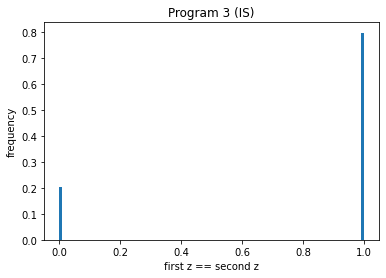

In [102]:
plt.hist(returns.numpy(), weights=normalized_weights.numpy(), bins=100)
plt.title("Program 3 (IS)")
plt.xlabel("first z == second z")
plt.ylabel("frequency")

## MH Gibbs

In [104]:
start = time.time()
ret_vals, jlls = gibbs_sampling(g3, 25000)
end = time.time()

In [105]:
print(end-start)

482.98594212532043


In [106]:
ret_vals = torch.stack(ret_vals).float()
mean = torch.mean(ret_vals)
var = torch.std(ret_vals)**2
jlls = torch.stack(jlls)
print("Expectation {}".format(mean.item()))
print("Variance {}".format(var.item()))

Expectation 0.6868399977684021
Variance 0.21509942412376404


Text(0, 0.5, 'frequency')

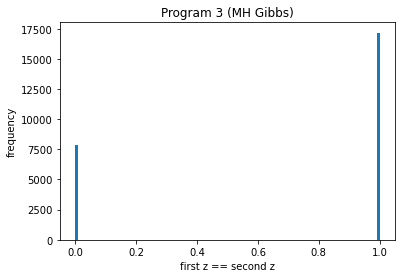

In [108]:
plt.hist(ret_vals.numpy(), bins=100)
plt.title("Program 3 (MH Gibbs)")
plt.xlabel("first z == second z")
plt.ylabel("frequency")

Text(0, 0.5, 'JLL')

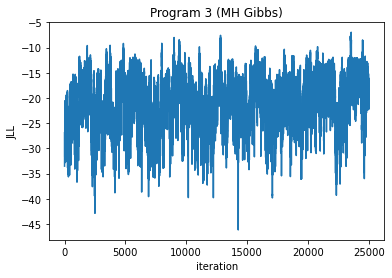

In [109]:
plt.plot(jlls)
plt.title("Program 3 (MH Gibbs)")
plt.xlabel("iteration")
plt.ylabel("JLL")

# Program 4

## Importance Sampling

In [110]:
start = time.time()
result = likelihood_weighting(ast4, 100000)
end = time.time()

In [111]:
print(end-start)

34.26541709899902


In [112]:
returns = torch.stack(result['returns']).float()
log_weights = torch.stack(result['log_weights'])
M = torch.max(log_weights)
normalized_weights = torch.exp(log_weights - M)/torch.sum(torch.exp(log_weights - M))
weighted_returns = normalized_weights*returns
expectation = torch.sum(weighted_returns)
returns_squared = returns*returns
variance = torch.sum(normalized_weights*returns_squared) - expectation*expectation
print("Expectation: {}".format(expectation.item()))
print("Variance: {}".format(variance.item()))

Expectation: 0.3207576870918274
Variance: 0.21787220239639282


Text(0, 0.5, 'frequency')

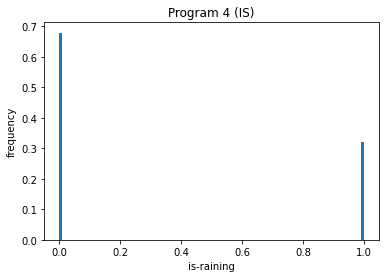

In [113]:
plt.hist(returns.numpy(), weights=normalized_weights.numpy(), bins=100)
plt.title("Program 4 (IS)")
plt.xlabel("is-raining")
plt.ylabel("frequency")

## MH Gibbs

In [4]:
start = time.time()
ret_vals, jlls = gibbs_sampling(g4, 100000)
end = time.time()

In [5]:
print(end-start)

264.28706216812134


In [6]:
ret_vals = torch.stack(ret_vals)
mean = torch.mean(ret_vals)
var = torch.std(ret_vals)**2
jlls = torch.stack(jlls).numpy()
print("Expectation: {}".format(mean.item()))
print("Variance: {}".format(var.item()))

Expectation: 0.3191699981689453
Variance: 0.21730266511440277


Text(0, 0.5, 'frequency')

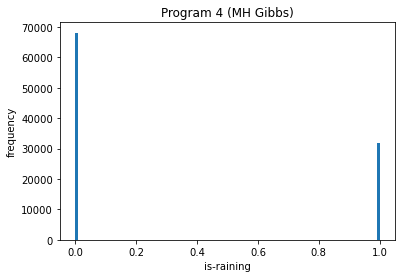

In [7]:
plt.hist(ret_vals.numpy(), bins=100)
plt.title("Program 4 (MH Gibbs)")
plt.xlabel("is-raining")
plt.ylabel("frequency")

Text(0, 0.5, 'JLL')

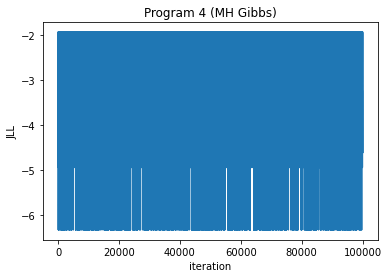

In [9]:
plt.plot(jlls)
plt.title("Program 4 (MH Gibbs)")
plt.xlabel("iteration")
plt.ylabel("JLL")

# Program 5

## Approximate Dirac with Tight Gaussian

One approach to this problem is to treat dirac(x) as a normal distribution with mean x and a small variance. By doing this multiple times, and making the variance smaller and smaller, the hope is that the posterior approaches the true posterior in the same sense that the normal approaches a dirac with increasing small variance.  

## Normal( loc = (+ x y), scale = 0.1)

I am only using HMC with this approach because both IS and MH Gibbs will clearly fail here.

In [9]:
start = time.time()
ret_vals, jlls = hmc(g5, 100000, epsilon=0.01, T=40)
end = time.time()

In [10]:
print(end-start)

2622.4215660095215


In [11]:
ret_vals = torch.stack(ret_vals).float()
jlls = torch.stack(jlls)
mean = torch.mean(ret_vals, dim=0).detach().numpy()
slope = ret_vals[:,0].detach().numpy()
bias = ret_vals[:,1].detach().numpy()
print("Expectation: {}".format(mean))
print("Covariance: ")
print(np.cov(slope, bias))

Expectation: [1.8033378 5.195167 ]
Covariance: 
[[ 40.88512909 -40.87774512]
 [-40.87774512  40.89461936]]


Text(0, 0.5, 'frequency')

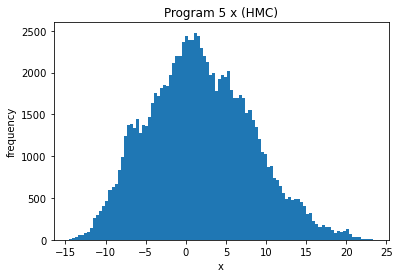

In [12]:
plt.hist(ret_vals[:,0].detach().numpy(), bins=100)
plt.title("Program 5 x (HMC)")
plt.xlabel("x")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

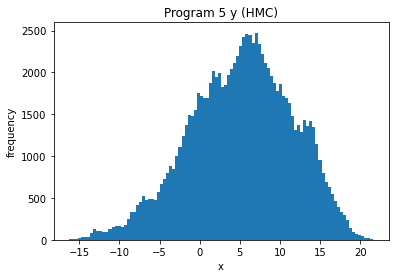

In [13]:
plt.hist(ret_vals[:,1].detach().numpy(), bins=100)
plt.title("Program 5 y (HMC)")
plt.xlabel("x")
plt.ylabel("frequency")

Text(0, 0.5, 'JLL')

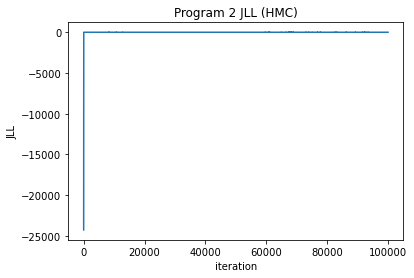

In [14]:
plt.plot(jlls.detach().numpy())
plt.title("Program 2 JLL (HMC)")
plt.xlabel("iteration")
plt.ylabel("JLL")

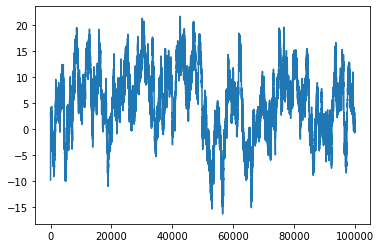

In [16]:
plt.plot(ret_vals[:,1].detach().numpy())

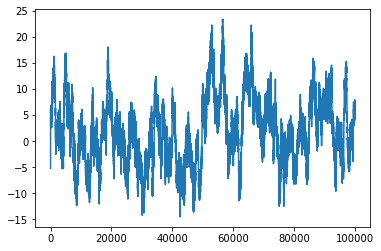

In [17]:
plt.plot(ret_vals[:, 0].detach().numpy())

## Normal(loc =(+ x y), scale=0.01)

In [3]:
start = time.time()
ret_vals, jlls = hmc(g5, 100000, epsilon=0.01, T=40)
end = time.time()

In [4]:
print(end-start)

2544.532530069351


In [5]:
ret_vals = torch.stack(ret_vals).float()
jlls = torch.stack(jlls)
mean = torch.mean(ret_vals, dim=0).detach().numpy()
slope = ret_vals[:,0].detach().numpy()
bias = ret_vals[:,1].detach().numpy()
print("Expectation: {}".format(mean))
print("Covariance: ")
print(np.cov(slope, bias))

Expectation: [13.420065 15.23371 ]
Covariance: 
[[ 47.96517076 -47.97522843]
 [-47.97522843  47.98601761]]


Text(0, 0.5, 'frequency')

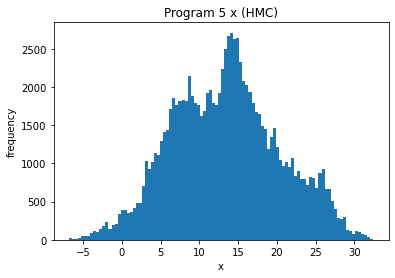

In [6]:
plt.hist(ret_vals[:,0].detach().numpy(), bins=100)
plt.title("Program 5 x (HMC)")
plt.xlabel("x")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

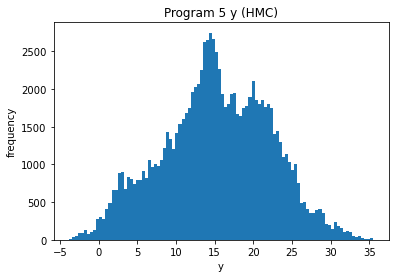

In [7]:
plt.hist(ret_vals[:,1].detach().numpy(), bins=100)
plt.title("Program 5 y (HMC)")
plt.xlabel("y")
plt.ylabel("frequency")

Text(0, 0.5, 'JLL')

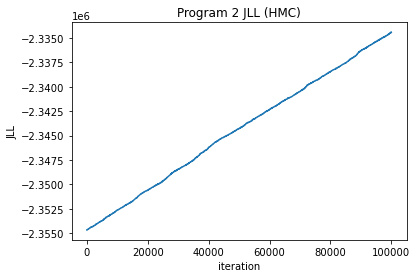

In [8]:
plt.plot(jlls.detach().numpy())
plt.title("Program 2 JLL (HMC)")
plt.xlabel("iteration")
plt.ylabel("JLL")

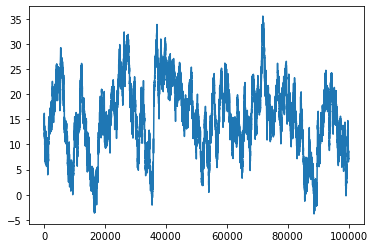

In [9]:
plt.plot(ret_vals[:,1].detach().numpy())

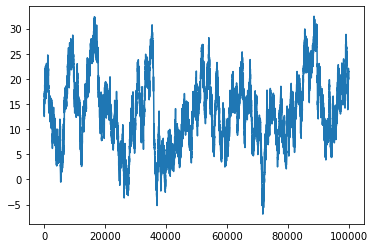

In [10]:
plt.plot(ret_vals[:, 0].detach().numpy())

In the above two results it is clear that neither is representative of the true posterior, which should be the same for both x and y due to symmetry. 

## Alternative idea: MH Gibbs with augmented proposal

(This idea was inspired by a discussion with Wilder Lavington about this problem - the majority of the credit goes to him here). 

Another possible approach is to alter the proposal so that we sample x from Normal(0, 10) and then y from Dirac(7-x), or vice versa (Wilder's idea). In this case the likelihood should cancel out in the in the MH acceptance ratio (my "idea"). Experimenting with this approach:

In [3]:
from mh_within_gibbs_program_5 import gibbs_sampling_p5

In [4]:
start = time.time()
ret_vals, jlls = gibbs_sampling_p5(g5, 100000)
end = time.time()

In [5]:
print(end-start)

100.62255477905273


In [11]:
#ret_vals = torch.stack(ret_vals).float()
#jlls = torch.stack(jlls)
mean = torch.mean(ret_vals, dim=0).numpy()
x = ret_vals[:,0].numpy()
y = ret_vals[:,1].numpy()
print("Expectation: {}".format(mean))
print("Covariance: ")
cov = np.cov(x, y)
print("x variance: {}".format(cov[0,0]))
print("y variance: {}".format(cov[1,1]))

Expectation: [0.04850821 6.951492  ]
Covariance: 
x variance: 100.06452849117163
y variance: 100.0645284682835


Text(0, 0.5, 'frequency')

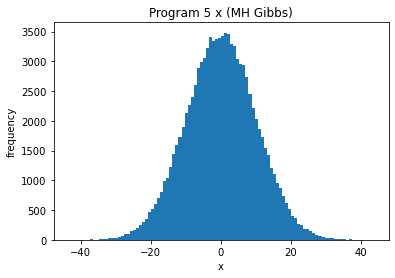

In [9]:
plt.hist(ret_vals[:,0].numpy(), bins=100)
plt.title("Program 5 x (MH Gibbs)")
plt.xlabel("x")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

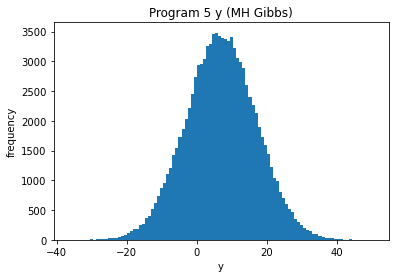

In [10]:
plt.hist(ret_vals[:,1].numpy(), bins=100)
plt.title("Program 5 y (MH Gibbs)")
plt.xlabel("y")
plt.ylabel("frequency")

In the above run, x was sampled from the prior and y was set to 7 - x. Since x is centred around 0, y ends up being centred around 7. Changing the code so that it alternates between choosing x and y from the prior yields the following results. 

In [3]:
from mh_within_gibbs_program_5 import gibbs_sampling_p5

In [4]:
start = time.time()
ret_vals, jlls = gibbs_sampling_p5(g5, 100000)
end = time.time()

In [5]:
print(end-start)

113.1631076335907


In [6]:
ret_vals = torch.stack(ret_vals).float()
jlls = torch.stack(jlls)
mean = torch.mean(ret_vals, dim=0).numpy()
x = ret_vals[:,0].numpy()
y = ret_vals[:,1].numpy()
print("Expectation: {}".format(mean))
print("Covariance: ")
cov = np.cov(x, y)
print("x variance: {}".format(cov[0,0]))
print("y variance: {}".format(cov[1,1]))

Expectation: [3.5000002 3.5011165]
Covariance: 
x variance: 112.76123930713004
y variance: 112.41367791192978


Text(0, 0.5, 'frequency')

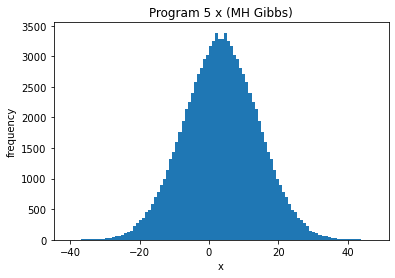

In [7]:
plt.hist(ret_vals[:,0].numpy(), bins=100)
plt.title("Program 5 x (MH Gibbs)")
plt.xlabel("x")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

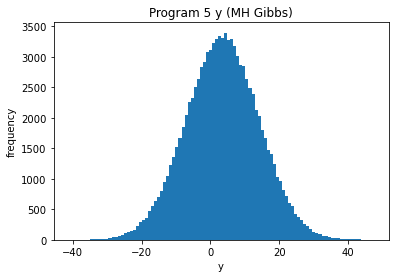

In [8]:
plt.hist(ret_vals[:,1].numpy(), bins=100)
plt.title("Program 5 y (MH Gibbs)")
plt.xlabel("y")
plt.ylabel("frequency")

Text(0, 0.5, 'x')

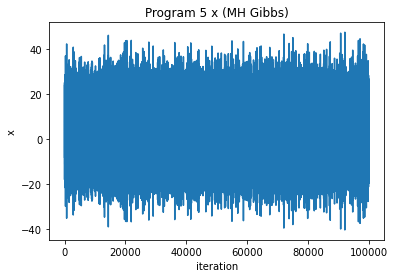

In [10]:
plt.plot(ret_vals[:,0].numpy())
plt.title("Program 5 x (MH Gibbs)")
plt.xlabel("iteration")
plt.ylabel("x")

Text(0, 0.5, 'y')

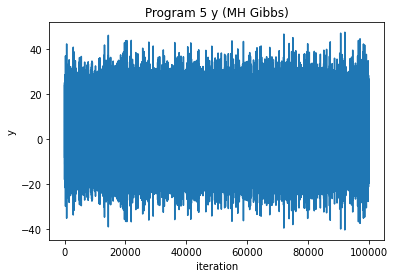

In [11]:
plt.plot(ret_vals[:,0].numpy())
plt.title("Program 5 y (MH Gibbs)")
plt.xlabel("iteration")
plt.ylabel("y")

Text(0, 0.5, 'JLL')

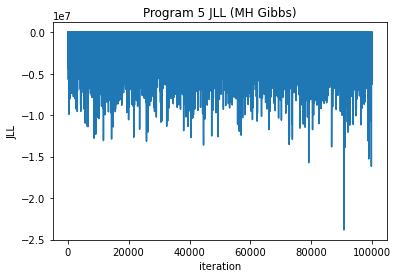

In [12]:
plt.plot(jlls.numpy())
plt.title("Program 5 JLL (MH Gibbs)")
plt.xlabel("iteration")
plt.ylabel("JLL")

These results look quite reasonable to me. One shortcoming of this approach - the code is very much tailored to this specific problem. I am unsure of how this could be generalized, if it could be at all. 

## Update

After submitting the first time I realized that my code is incorrect. Specifically, the q distributions being used in the MH ratio are not the correct q's (I left them as the prior, despite the fact that for every second acceptance ratio computed the q is a Dirac). I worried that fixing this would break the code, as q(x|X') would be zero in this circumstance. Further, I realized that the likelihoods DO NOT cancel - since we are doing Gibbs rather than block Gibbs, one of the likelihood terms will be zero as well. It turns out that neither of these issues are issues, as they cancel each other out (see written work appended). However, on the updates with Dirac proposals the acceptance rate is not one (again see written work) and so there will be samples where x and y do not add up to 7. I haven't quite determined if this is a problem in terms of whether or not the analysis works out correctly, but the solution is relatively simple - using block Gibbs updates for x and y. Derivation of these updates is also in the appended written work. I may be overlooking something in this derivation, but will implement it and see if it changes the result. As an added note, the joint log likelihood above was using the Normal approximation to Dirac, which was an oversight rather than an intention. This will be fixed in the block Gibbs code below. 

In [ ]:
# updated code snippets for block gibbs...
# some weird logic; this was written in haste

def gibbs_sampling_p5(graph, S, X0=None, verbose=False, return_samples=False):

    if return_samples:
        samples = [None]*S
    
    jlls = [None]*S
    ret_vals = [None]*S

    # sample from proposal
    if X0 is None:
        X0 = sample_from_prior(graph)
        P = graph[1]['P']
        Xkeys = list(X0.keys())
        task, expr = P[Xkeys[0]][0], P[Xkeys[0]][1]
        assert task == "sample*", "Found observed variable in X???"
        q0, _ = deterministic_evaluate(expr, X0)
        X0[Xkeys[0]] = q0.sample()
        X0[Xkeys[1]] = 7 - X0[Xkeys[0]]

    Xprev = X0

    for s in range(S):
        if verbose:
            print(s)
        X, ret_vals[s] = block_gibbs_step(Xprev, graph, s)
        if return_samples:
            samples[s] = X
        jlls[s] = joint_log_likelihood(X, graph)
        Xprev = X

    if return_samples:
        return ret_vals, jlls, samples
    else:
        return ret_vals, jlls


def block_gibbs_step(X, graph, s):

    P = graph[1]['P']
    unif = torch.distributions.Uniform(0,1)
    Xkeys = list(X.keys())
    ret_vals = graph[2]

    if s % 2 == 0:
        sampled = 'sample1'
        deterministic = 'sample2'
    else:
        sampled = 'sample2'
        deterministic = 'sample1'

    # sample a new X from block proposal
    expr = P[sampled][1]
    q_sampled, _ =  deterministic_evaluate(expr, X)
    Xprime = X.copy()
    Xprime[sampled] = q_sampled.sample()
    Xprime[deterministic] = 7 - Xprime[sampled]
    # compute alpha
    alpha = accept(deterministic, Xprime, X, graph)
    u = unif.sample()
    if u < alpha:
        X = Xprime

    return X, deterministic_evaluate(ret_vals, X)[0]


def accept(x, Xprime, X, graph):

    P = graph[1]['P']
    log_alpha = 0.0

    expr = P[x][1]
    p, _ = deterministic_evaluate(expr, X)
    log_alpha += (p.log_prob(Xprime[x]) - p.log_prob(X[x]))

    return torch.exp(log_alpha)

def joint_log_likelihood(X, graph):
    P = graph[1]['P']
    V = X
    Vkeys = list(V.keys())
    jll = 0

    for v in Vkeys:
        expr = P[v][1]
        p_v, _ = deterministic_evaluate(expr, V)
        jll += p_v.log_prob(V[v])

    return jll

Results:

In [3]:
from mh_within_gibbs_program_5 import gibbs_sampling_p5

start = time.time()
ret_vals, jlls = gibbs_sampling_p5(g5, 100000)
end = time.time()

In [4]:
print(end-start)

43.109814167022705


In [5]:
ret_vals = torch.stack(ret_vals).float()
jlls = torch.stack(jlls)
mean = torch.mean(ret_vals, dim=0).numpy()
x = ret_vals[:,0].numpy()
y = ret_vals[:,1].numpy()
print("Expectation: {}".format(mean))
cov = np.cov(x, y)
print("x variance: {}".format(cov[0,0]))
print("y variance: {}".format(cov[1,1]))

Expectation: [3.4890962 3.5109038]
x variance: 49.99359296645907
y variance: 49.99359297861461


Text(0, 0.5, 'frequency')

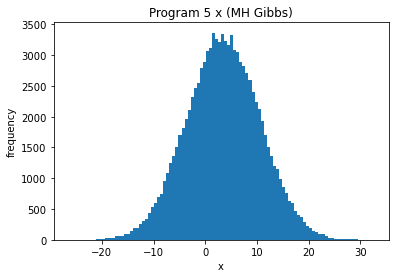

In [6]:
plt.hist(ret_vals[:,0].numpy(), bins=100)
plt.title("Program 5 x (MH Gibbs)")
plt.xlabel("x")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

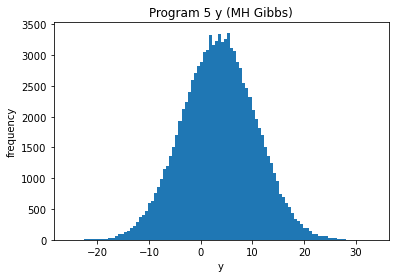

In [7]:
plt.hist(ret_vals[:,1].numpy(), bins=100)
plt.title("Program 5 y (MH Gibbs)")
plt.xlabel("y")
plt.ylabel("frequency")

Text(0, 0.5, 'x')

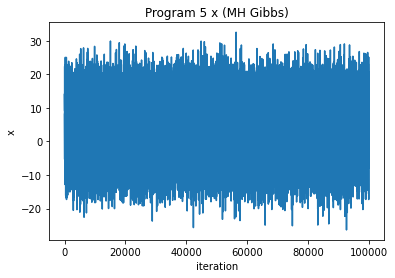

In [8]:
plt.plot(ret_vals[:,0].numpy())
plt.title("Program 5 x (MH Gibbs)")
plt.xlabel("iteration")
plt.ylabel("x")

Text(0, 0.5, 'y')

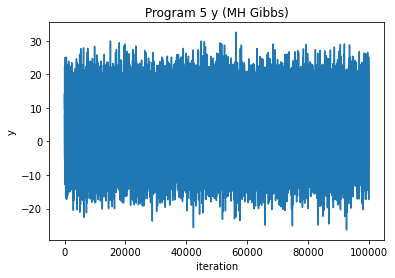

In [9]:
plt.plot(ret_vals[:,0].numpy())
plt.title("Program 5 y (MH Gibbs)")
plt.xlabel("iteration")
plt.ylabel("y")

Text(0, 0.5, 'JLL')

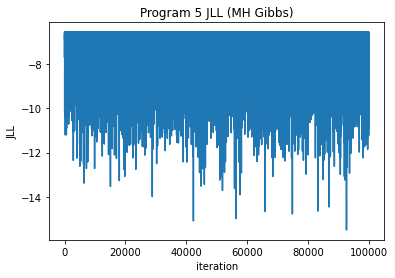

In [10]:
plt.plot(jlls.numpy())
plt.title("Program 5 JLL (MH Gibbs)")
plt.xlabel("iteration")
plt.ylabel("JLL")

The main effect of this, in terms of results, seems to have been reducing marginal variance in each of the variables (the means are the same). Again, these results seem reasonable. Is my approach reasonable? I'm really not sure. 